# Calibration with conformal inference

TODO:
1. Add an example to differ conditional calibration and overall calibration.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import pickle
import os
import admix_prs
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# target at [5%, 95%] interval
TARGET_QUANTILE = 0.05
TARGET_QUANTILE_Z = scipy.stats.norm.ppf(1 - TARGET_QUANTILE)

np.random.seed(1)

In [3]:
with open("df_res_list.pkl", "rb") as f:
    df_res_list = pickle.load(f)

In [4]:
df_raw = df_res_list[0].copy()
hsq = 0.25

# correct for the PRS-MEAN, such that it has the same mean as the PHENO
df_raw["PRS_MEAN"] -= df_raw["PRS_MEAN"].mean() - df_raw["PHENO"].mean()

df_raw["PHENO_STD"] = np.sqrt(df_raw["PRS_STD"] ** 2 + (1 - hsq))
df_raw["PHENO_LOWER"] = df_raw["PRS_MEAN"] - df_raw["PHENO_STD"] * TARGET_QUANTILE_Z
df_raw["PHENO_UPPER"] = df_raw["PRS_MEAN"] + df_raw["PHENO_STD"] * TARGET_QUANTILE_Z
df_raw["PRS_LOWER"] = df_raw["PRS_MEAN"] - df_raw["PRS_STD"] * TARGET_QUANTILE_Z
df_raw["PRS_UPPER"] = df_raw["PRS_MEAN"] + df_raw["PRS_STD"] * TARGET_QUANTILE_Z

# generate some random covariates
df_raw["AGE"] = np.random.randint(100, size=len(df_raw))
df_raw["SEX"] = np.random.randint(2, size=len(df_raw))

In [5]:
display(
    admix_prs.eval_calibration(
        df_raw,
        x_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
    )
)

display(
    admix_prs.eval_calibration(
        df_raw,
        x_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="SEX",
    )
)

coverage    0.899745
dtype: float64

,SEX,coverage
0,0,0.899711
1,1,0.899779


# Case 1: phenotype mean as a function of covariates

In [6]:
df1 = df_raw.copy()
df1["PHENO"] += (df1["SEX"] - 0.5) * 3

,SEX,coverage
0,0,0.496890
1,1,0.496727


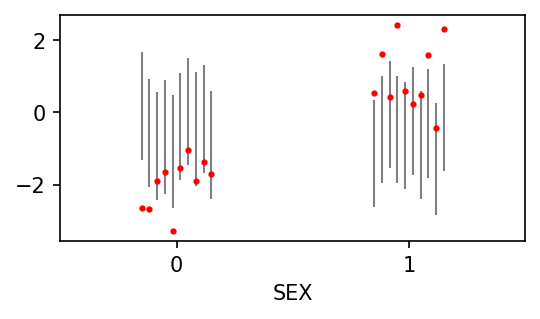

In [7]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=150)
admix_prs.plot_calibration(
    df=df1,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="SEX",
    ax=ax,
)
display(
    admix_prs.eval_calibration(
        df1,
        x_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="SEX",
    )
)

2022-01-19 14:27.13 [info     ] Regress pred_col=PRS_MEAN against mean_adjust_cols=['SEX'] fitted with `calibrate_index` individuals
2022-01-19 14:27.13 [info     ] method=None, no further adjustment to the intervals, only mean shift


,SEX,coverage
0,0,0.899346
1,1,0.900488


Text(0.5, 1.0, 'After')

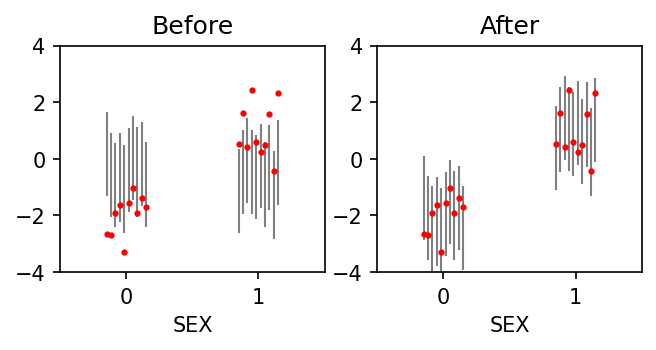

In [8]:
np.random.seed(1)
# use 5% of the individual for calibration
calibrate_idx = np.random.choice(df1.index, size=int(len(df1) * 0.05), replace=False)

# perform calibration
df1_calibrated = admix_prs.calibrate_pred(
    df1,
    pheno_col="PHENO",
    pred_col="PRS_MEAN",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    calibrate_idx=calibrate_idx,
    mean_adjust_cols=["SEX"],
)
df1_calibrated[["PHENO", "SEX"]] = df1[["PHENO", "SEX"]].reindex(df1_calibrated.index)

display(
    admix_prs.eval_calibration(
        df1_calibrated,
        x_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="SEX",
    )
)

# visualize before and after

fig, axes = plt.subplots(figsize=(5, 2), dpi=150, ncols=2)
admix_prs.plot_calibration(
    df=df1,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="SEX",
    ax=axes[0],
)

admix_prs.plot_calibration(
    df=df1_calibrated,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="SEX",
    ax=axes[1],
)
axes[0].set_ylim(-4, 4)
axes[0].set_title("Before")
axes[1].set_ylim(-4, 4)
axes[1].set_title("After")

# Case 2: variance as a function of covariates

In [9]:
df2 = df_raw.copy()
df2["PHENO"] += np.random.normal(scale=np.sqrt(df2["AGE"]) * 0.4)
df2["AGE_Q"] = pd.qcut(df2["AGE"], q=5).cat.codes

np.random.seed(1)
# use 5% of the individual for calibration
calibrate_idx = np.random.choice(df2.index, size=int(len(df2) * 0.05), replace=False)

# perform calibration
df2_calibrated = admix_prs.calibrate_pred(
    df2,
    pheno_col="PHENO",
    pred_col="PRS_MEAN",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    calibrate_idx=calibrate_idx,
    mean_adjust_cols=["AGE"],
)
df2_calibrated[["PHENO", "AGE_Q"]] = df2[["PHENO", "AGE_Q"]].reindex(
    df2_calibrated.index
)

2022-01-19 14:27.14 [info     ] Regress pred_col=PRS_MEAN against mean_adjust_cols=['AGE'] fitted with `calibrate_index` individuals
2022-01-19 14:27.14 [info     ] method=None, no further adjustment to the intervals, only mean shift


,AGE_Q,coverage
0,0,0.685443
1,1,0.465400
2,2,0.384368
3,3,0.332992
4,4,0.298350


,AGE_Q,coverage
0,0,0.680055
1,1,0.468085
2,2,0.386545
3,3,0.331356
4,4,0.298026


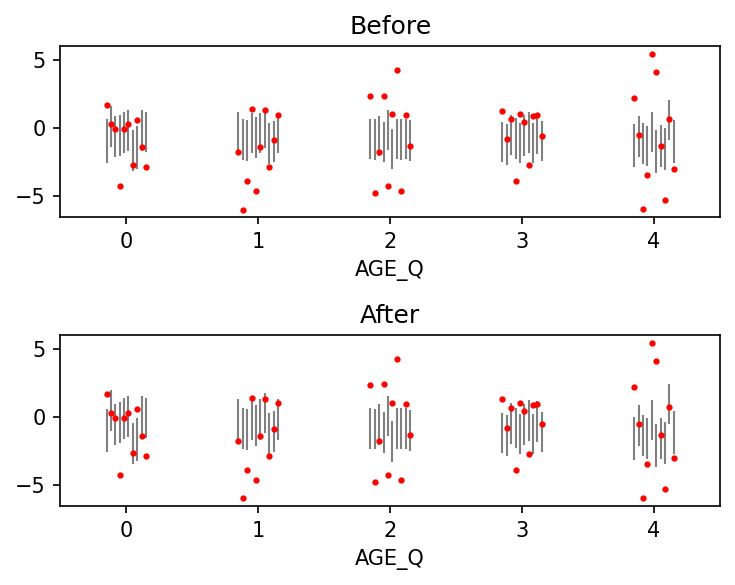

In [10]:
fig, axes = plt.subplots(figsize=(5, 4), dpi=150, nrows=2)
admix_prs.plot_calibration(
    df=df2,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="AGE_Q",
    n=10,
    ax=axes[0],
)
axes[0].set_title("Before")
display(
    admix_prs.eval_calibration(
        df=df2,
        x_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="AGE_Q",
    )
)
admix_prs.plot_calibration(
    df=df2_calibrated,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="AGE_Q",
    n=10,
    ax=axes[1],
)
axes[1].set_title("After")

display(
    admix_prs.eval_calibration(
        df=df2_calibrated,
        x_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="AGE_Q",
    )
)
fig.tight_layout()

In [11]:
# perform calibration with TARGET_QUANTILE adjusted
df2_calibrated = admix_prs.calibrate_pred(
    df2,
    pheno_col="PHENO",
    pred_col="PRS_MEAN",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    calibrate_idx=calibrate_idx,
    method="scale",
    quantile_adjust_cols=["AGE"],
    q=TARGET_QUANTILE,
)
df2_calibrated[["PHENO", "AGE_Q"]] = df2[["PHENO", "AGE_Q"]].reindex(
    df2_calibrated.index
)

2022-01-19 14:27.14 [info     ] Regress pred_col=PRS_MEAN against mean_adjust_cols=[] fitted with `calibrate_index` individuals
2022-01-19 14:27.14 [info     ] method=scale, scale the interval length to the target quantile 0.05 using quantile_adjust_cols=['AGE'] with `calibrate_index` individuals


,AGE_Q,coverage
0,0,0.685443
1,1,0.465400
2,2,0.384368
3,3,0.332992
4,4,0.298350


,AGE_Q,coverage
0,0,0.914381
1,1,0.881843
2,2,0.891676
3,3,0.910207
4,4,0.924711


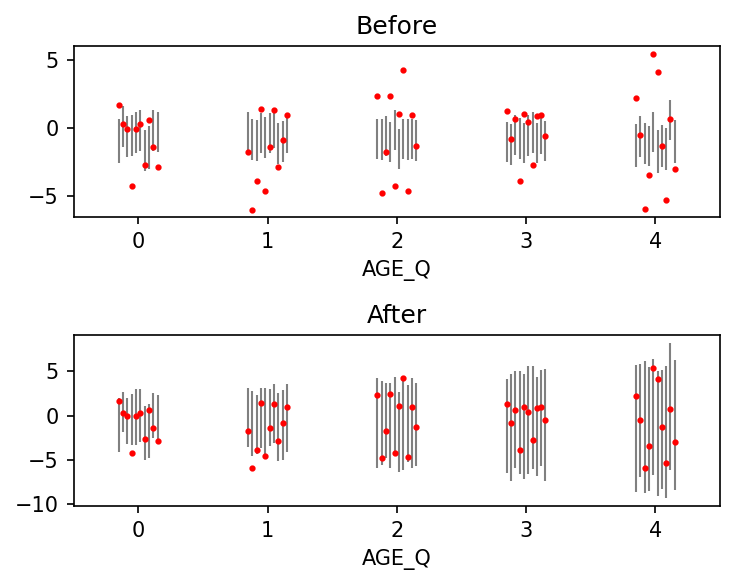

In [12]:
fig, axes = plt.subplots(figsize=(5, 4), dpi=150, nrows=2)
admix_prs.plot_calibration(
    df=df2,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="AGE_Q",
    n=10,
    ax=axes[0],
)
axes[0].set_title("Before")
display(
    admix_prs.eval_calibration(
        df=df2,
        x_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="AGE_Q",
    )
)

admix_prs.plot_calibration(
    df=df2_calibrated,
    y_col="PHENO",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="AGE_Q",
    n=10,
    ax=axes[1],
)
axes[1].set_title("After")

display(
    admix_prs.eval_calibration(
        df=df2_calibrated,
        x_col="PHENO",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="AGE_Q",
    )
)
fig.tight_layout()